1) Посмотрим на соотношение задержки и количества рейсов

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv(r"C:\Users\maest\Downloads\flights.csv")

C:\Users\maest\AppData\Local\Temp\ipykernel_17552\3220881445.py:5: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\maest\Downloads\flights.csv")


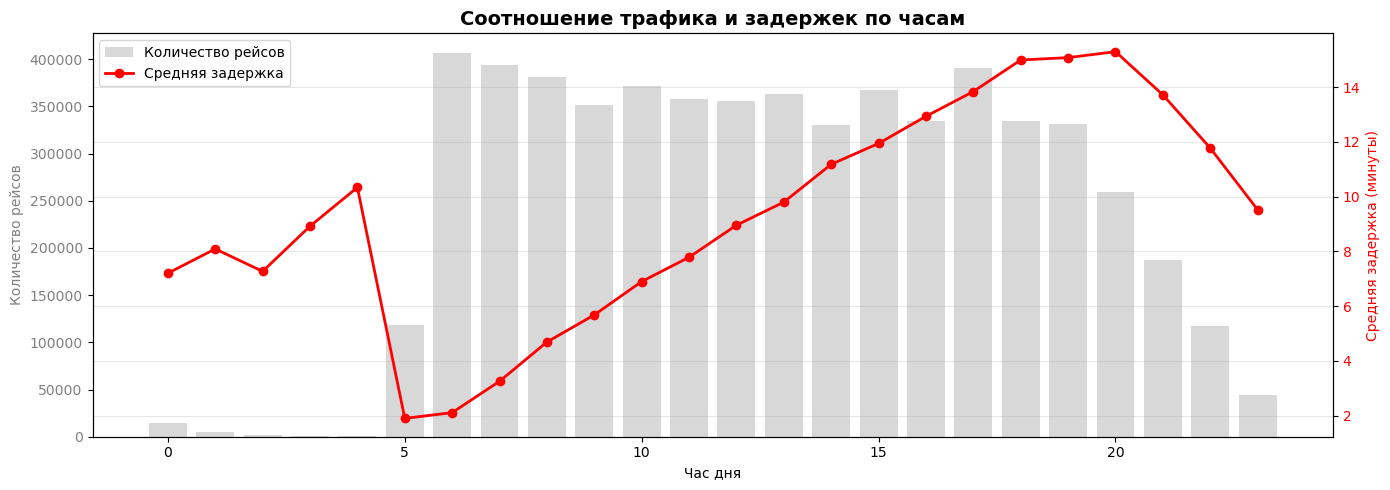

In [2]:
hourly_extreme = df.groupby(df['SCHEDULED_DEPARTURE'] // 100).agg({
    'DEPARTURE_DELAY': ['mean', lambda x: (x > 60).mean(), lambda x: (x > 180).mean()],
    'FLIGHT_NUMBER': 'count'
}).round(3)

hourly_extreme.columns = ['Средняя_задержка', 'Доля_задержек_>1ч', 'Доля_задержек_>3ч', 'Количество_рейсов']

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 5))

hours = hourly_extreme.index
ax1.bar(hours, hourly_extreme['Количество_рейсов'], alpha=0.3, color='gray', label='Количество рейсов')
ax1.set_ylabel('Количество рейсов', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

ax1_twin = ax1.twinx()
ax1_twin.plot(hours, hourly_extreme['Средняя_задержка'], 'ro-', linewidth=2, markersize=6, label='Средняя задержка')
ax1_twin.set_ylabel('Средняя задержка (минуты)', color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')
ax1_twin.grid(True, alpha=0.3)

ax1.set_title('Соотношение трафика и задержек по часам', fontsize=14, fontweight='bold')
ax1.set_xlabel('Час дня')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')


plt.tight_layout()
plt.show()

Видим, что в течении дня задержка накапливается, из-за чего даже если рейсов очень мало, то она все равно есть

2) Посмотрим есть ли зависимоть задержки от региона

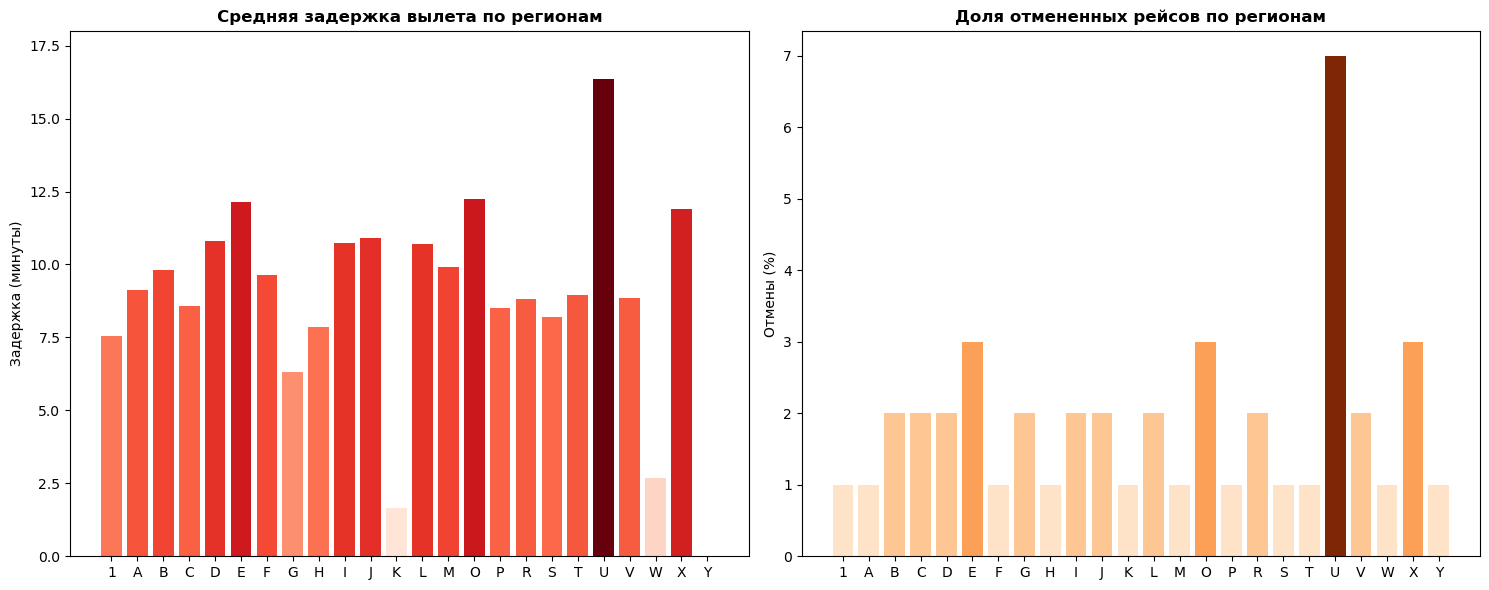

Проблемные регионы:


,Средняя_задержка_вылета,Доля_отмен
REGION,,
U,16.37,0.07
O,12.25,0.03
E,12.14,0.03


In [3]:
df['REGION'] = df['ORIGIN_AIRPORT'].str[0]

regional_analysis = df.groupby('REGION').agg({
    'DEPARTURE_DELAY': ['mean', 'std'],
    'ARRIVAL_DELAY': 'mean',
    'CANCELLED': 'mean',
    
}).round(2)

regional_analysis.columns = ['Средняя_задержка_вылета', 'Отклонение_задержки', 
                            'Средняя_задержка_прилета', 'Доля_отмен'
                            ]

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6))

regions = regional_analysis.index
delays = regional_analysis['Средняя_задержка_вылета']
ax1.bar(regions, delays, color=plt.cm.Reds(delays / delays.max()))
ax1.set_ylim(0, max(delays) * 1.1)
ax1.set_title('Средняя задержка вылета по регионам', fontweight='bold')
ax1.set_ylabel('Задержка (минуты)')

cancellations = regional_analysis['Доля_отмен'] * 100
ax2.bar(regions, cancellations, color=plt.cm.Oranges(cancellations / cancellations.max()))
ax2.set_title('Доля отмененных рейсов по регионам', fontweight='bold')
ax2.set_ylabel('Отмены (%)')

plt.tight_layout()
plt.show()

print("Проблемные регионы:")
regional_analysis.nlargest(3, 'Средняя_задержка_вылета')[['Средняя_задержка_вылета', 'Доля_отмен']]

Да явно видно что несколько регионов выделяются, видимо связанно из-за плохой инфраструктуры

3) Если ли авиакомпании которые чеще страдают из-за погодных условий 

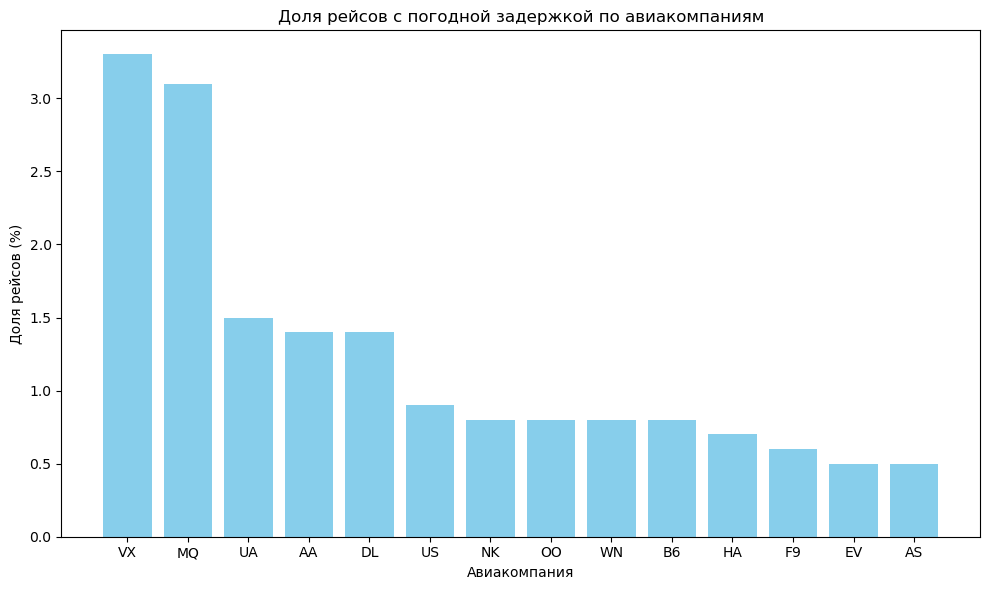

In [4]:
weather_delay_stats = df.groupby('AIRLINE')['WEATHER_DELAY'].apply(
    lambda x: (x > 0).sum() / len(x) * 100
).round(1)

weather_delay_stats = weather_delay_stats.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(weather_delay_stats.index, weather_delay_stats.values, color='skyblue')
plt.title('Доля рейсов с погодной задержкой по авиакомпаниям')
plt.ylabel('Доля рейсов (%)')
plt.xlabel('Авиакомпания')

plt.tight_layout()
plt.show()

Очевидно выделяются 2

4) Посмотрим зависимость задержки от типа самолета

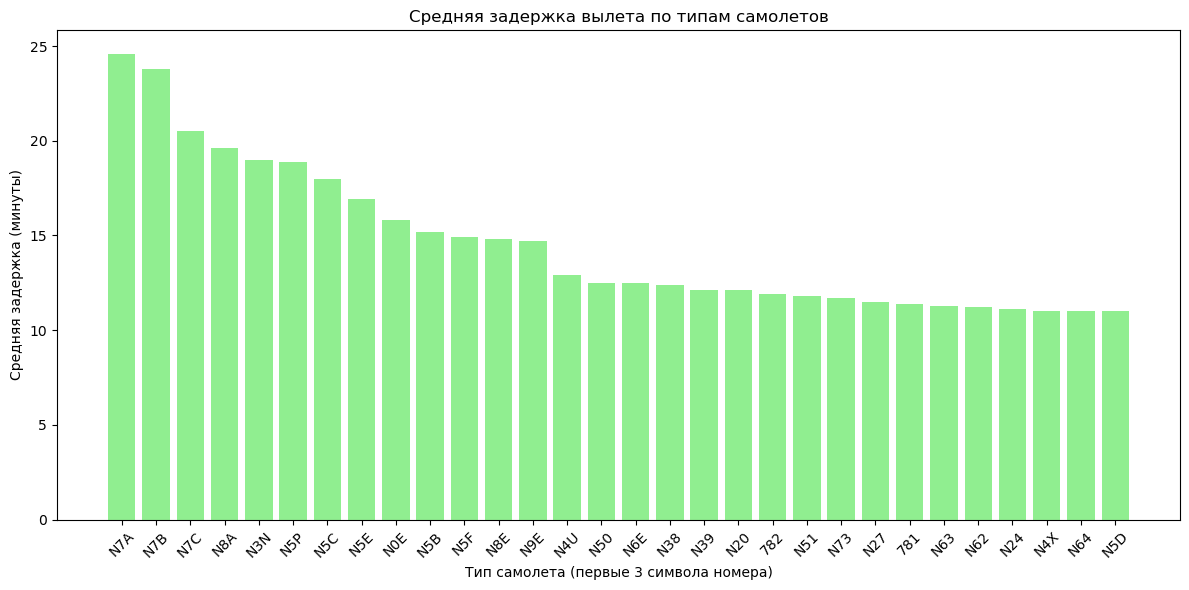

In [6]:
df['AIRCRAFT_TYPE'] = df['TAIL_NUMBER'].str[:3]

aircraft_delay_stats = df.groupby('AIRCRAFT_TYPE').agg({
    'DEPARTURE_DELAY': ['mean', 'count']
}).round(1)

aircraft_delay_stats.columns = ['Средняя_задержка', 'Количество_рейсов']
aircraft_delay_stats = aircraft_delay_stats[aircraft_delay_stats['Количество_рейсов'] > 100]
aircraft_delay_stats = aircraft_delay_stats.sort_values('Средняя_задержка', ascending=False).head(30)


plt.figure(figsize=(12, 6))
plt.bar(aircraft_delay_stats.index, aircraft_delay_stats['Средняя_задержка'], color='lightgreen')
plt.title('Средняя задержка вылета по типам самолетов')
plt.ylabel('Средняя задержка (минуты)')
plt.xlabel('Тип самолета (первые 3 символа номера)')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

В целом выделяются по большей части 2, может быть устаревшие модели

5) Зависимоть задержки от дальности полета 

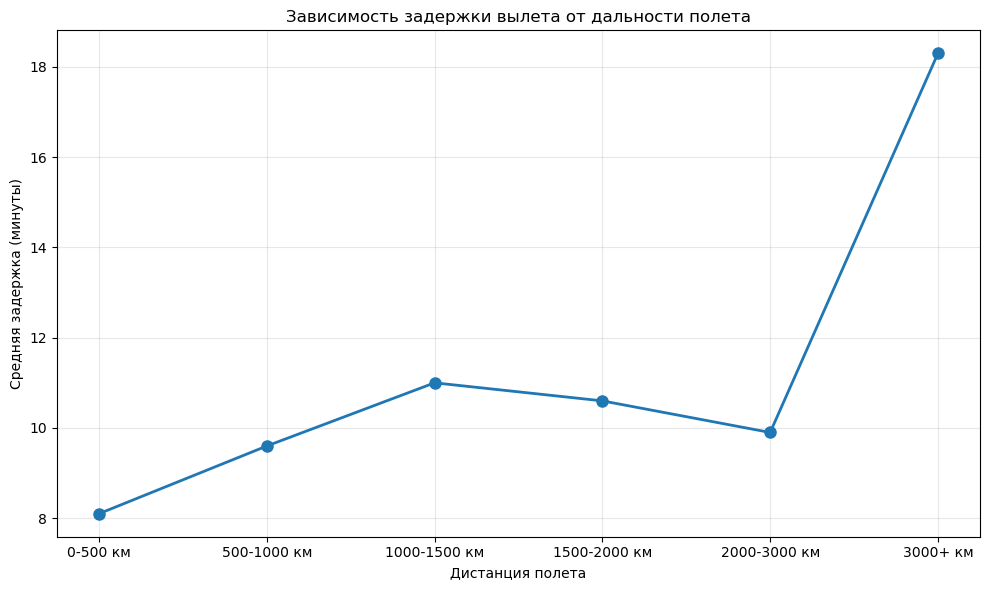

In [8]:
distance_bins = [0, 500, 1000, 1500, 2000, 3000, 5000]
distance_labels = ['0-500 км', '500-1000 км', '1000-1500 км', '1500-2000 км', '2000-3000 км', '3000+ км']

df['DISTANCE_CATEGORY'] = pd.cut(df['DISTANCE'], bins=distance_bins, labels=distance_labels)
distance_delay_stats = df.groupby('DISTANCE_CATEGORY', observed=False)['DEPARTURE_DELAY'].mean().round(1)

plt.figure(figsize=(10, 6))
plt.plot(distance_delay_stats.index, distance_delay_stats.values, 'o-', linewidth=2, markersize=8)
plt.title('Зависимость задержки вылета от дальности полета')
plt.ylabel('Средняя задержка (минуты)')
plt.xlabel('Дистанция полета')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Видим, что на межконтенинтальные полеты задердка больше чем на не далекие полеты